# DLCV HW\#2 - d05921027 張鈞閔

In [1]:
import os
import numpy as np
import cv2
import scipy.io
import scipy.signal
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

## Problem 1 

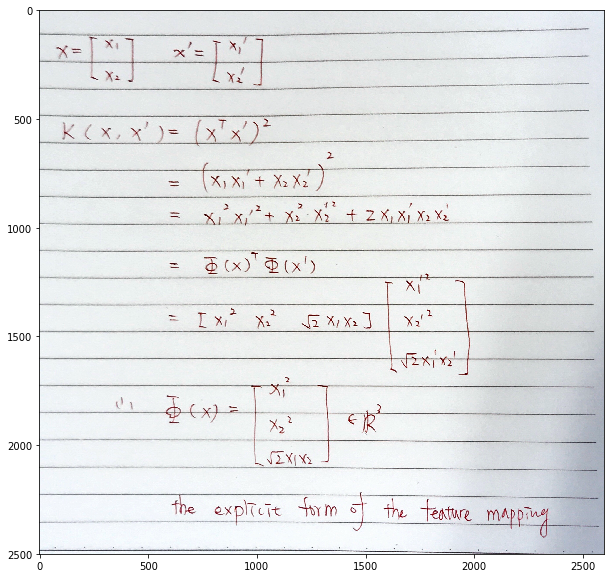

In [2]:
image = cv2.imread("Problem1.JPG")
plt.figure(figsize=(16,10))
plt.imshow(image)

## Problem 2 

### (a) color segmentation 

In [3]:
def TenColorKMeans(img_path, use_lab=False):
    image = cv2.imread(img_path)
    if use_lab:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    flatten_image = image.reshape(-1,3)
    kmeans = KMeans(n_clusters=10,max_iter=1000)
    kmeans.fit(flatten_image)
    
    color_array = [[166,206,227],[31,120,180],[178,223,138],[51,160,44],[251,154,153],
                   [227,26,28],[253,191,111],[255,127,0],[202,178,214],[106,61,154]]

    res_image = np.array([color_array[i] for i in kmeans.labels_])
    res_image = res_image.reshape(image.shape)
    return res_image

### (a-i) RGB color space

In [4]:
mountain = TenColorKMeans("Problem2/mountain.jpg")
zebra = TenColorKMeans("Problem2/zebra.jpg")

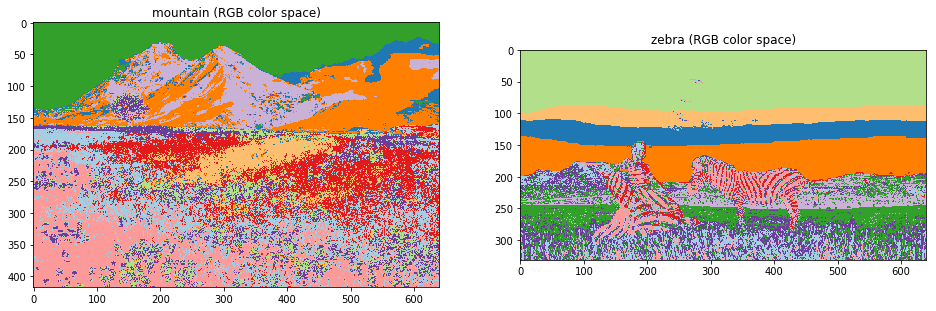

In [5]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("mountain (RGB color space)")
plt.imshow(mountain)
plt.subplot(1,2,2)
plt.title("zebra (RGB color space)")
plt.imshow(zebra)
plt.show()

### (a-ii) Lab color space 

In [6]:
mountain_lab = TenColorKMeans("Problem2/mountain.jpg", use_lab=True)
zebra_lab = TenColorKMeans("Problem2/zebra.jpg", use_lab=True)

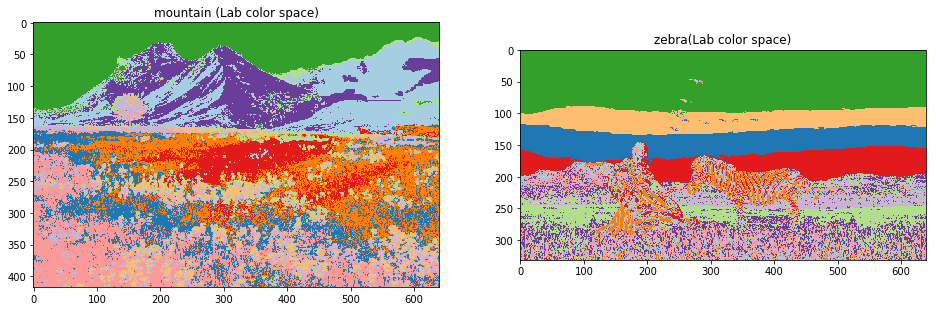

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("mountain (Lab color space)")
plt.imshow(mountain_lab)
plt.subplot(1,2,2)
plt.title("zebra(Lab color space)")
plt.imshow(zebra_lab)
plt.show()

### (b) texture segmentation 

### (b-i)  texture only

In [8]:
def TextureKMeans(image_path, add_lab=False):
    image = cv2.imread(image_path)
    
    # convert to gray scale
    grayimage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # load existing filters
    filters = scipy.io.loadmat('Problem2/filterBank.mat')["F"]
    
    # generate feature maps
    
    feature_map = []
    for i in range(filters.shape[2]):
        conv = scipy.signal.convolve2d(grayimage, filters[:,:,i], mode="same", boundary="symm")
        feature_map.append(conv)
    feature_map = np.dstack(feature_map)
    
    # flatten feature maps
    flatten_map = feature_map.reshape(-1,38)
    
    # add flatten lab features or not
    if add_lab:
        labimage = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        flatten_lab = labimage.reshape(-1,3)
        flatten_map = np.concatenate((flatten_map, flatten_lab), axis=1)
        
    
    # perform KMeans
    kmeans = KMeans(n_clusters=6,max_iter=1000)
    kmeans.fit(flatten_map)
    
    # conver to specific 6 colors
    color_array = [[166,206,227],[31,120,180],[178,223,138],[51,160,44],[251,154,153],[227,26,28]]

    res_image = np.array([color_array[i] for i in kmeans.labels_])
    res_image = res_image.reshape(image.shape)
    return res_image

In [9]:
mountain_texture = TextureKMeans("Problem2/mountain.jpg")
zebra_texture = TextureKMeans("Problem2/zebra.jpg")

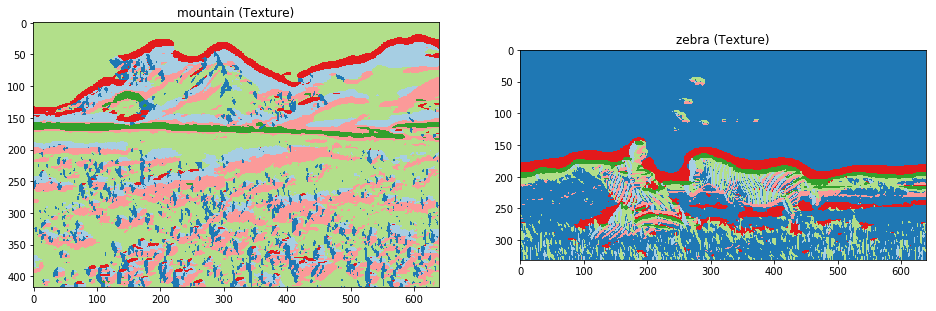

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("mountain (Texture)")
plt.imshow(mountain_texture)
plt.subplot(1,2,2)
plt.title("zebra (Texture)")
plt.imshow(zebra_texture)
plt.show()

### (b-ii) RGB+texture 

In [11]:
mountain_rgb_texture = TextureKMeans("Problem2/mountain.jpg", add_lab=True)
zebra_rgb_texture = TextureKMeans("Problem2/zebra.jpg", add_lab=True)

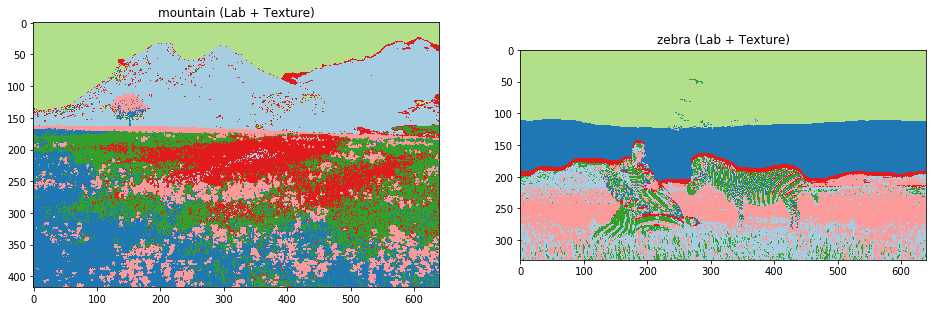

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("mountain (Lab + Texture)")
plt.imshow(mountain_rgb_texture)
plt.subplot(1,2,2)
plt.title("zebra (Lab + Texture)")
plt.imshow(zebra_rgb_texture)
plt.show()

## Problem 3 

### (a) randomly sample one image and extract its top 30 SURF interest points

In [13]:
def ExtractSURF(image,thre):
    surf = cv2.xfeatures2d.SURF_create(thre)
    points, descriptors = surf.detectAndCompute(image, None)
    return points, descriptors

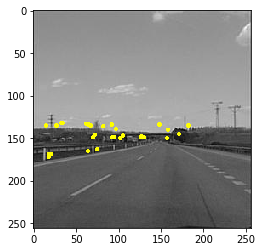

In [14]:
image = cv2.imread("Problem3/train-10/Highway/image_0009.jpg",0) # read in grayscale
points, descriptors = ExtractSURF(image,1700)
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
for p in points:
    cv2.circle(color_image, (int(p.pt[0]),int(p.pt[1])), radius=1, color=(255,255,0), thickness=2)
plt.imshow(color_image)
plt.show()

### (b) Visual words (KMeans) on the Train-10 dataset and Visualize in PCA features

In [15]:
file_list = []
for dirPath, dirNames, fileNames in os.walk("Problem3/train-10/"):
    for file in fileNames:
        file_list.append(os.path.join(dirPath, file))

In [16]:
sep_points_list = []
sep_descriptors_list = []
for file in file_list:
    image = cv2.imread(file,0)
    points, descriptors = ExtractSURF(image,1000)
    sep_points_list.append(points)
    sep_descriptors_list.append(descriptors)
points_list = np.concatenate(sep_points_list,axis=0)
descriptors_list = np.concatenate(sep_descriptors_list,axis=0)

print("interest points", points_list.shape)
print("descriptors:", descriptors_list.shape)

interest points (9332,)
descriptors: (9332, 64)


In [17]:
# perform KMeans, C=50, iter=5000
kmeans = KMeans(n_clusters=50,max_iter=5000)
kmeans.fit(descriptors_list)

# get centers and cluster labels
centers = kmeans.cluster_centers_
clusters = kmeans.labels_

In [18]:
# PCA
pca = PCA(n_components=3)
pca_descriptors = pca.fit_transform(descriptors_list)
print("pca descriptors:",pca_descriptors.shape)

pca descriptors: (9332, 3)


In [19]:
# sample 6 clusters
sample_clusters = np.random.choice(np.unique(clusters), size=6, replace=False)

# sampled 6 centers and its pca
sample_centers = centers[sample_clusters]
sample_pca_centers = pca.transform(sample_centers)

In [20]:
# generate color dictionary for the 6 sampled clusters
color_array = ['b', 'g', 'r', 'c', 'm', 'y']
color_dict = dict()
for idx,clu in enumerate(sample_clusters):
    color_dict[clu] = color_array[idx]

In [21]:
# sampled descriptors and its pca
sample_pca_descriptors = pca_descriptors[np.isin(element=clusters,test_elements=sample_clusters)]
sample_colors = []
for clu in clusters[np.isin(element=clusters,test_elements=sample_clusters)]:
    sample_colors.append(color_dict[clu])

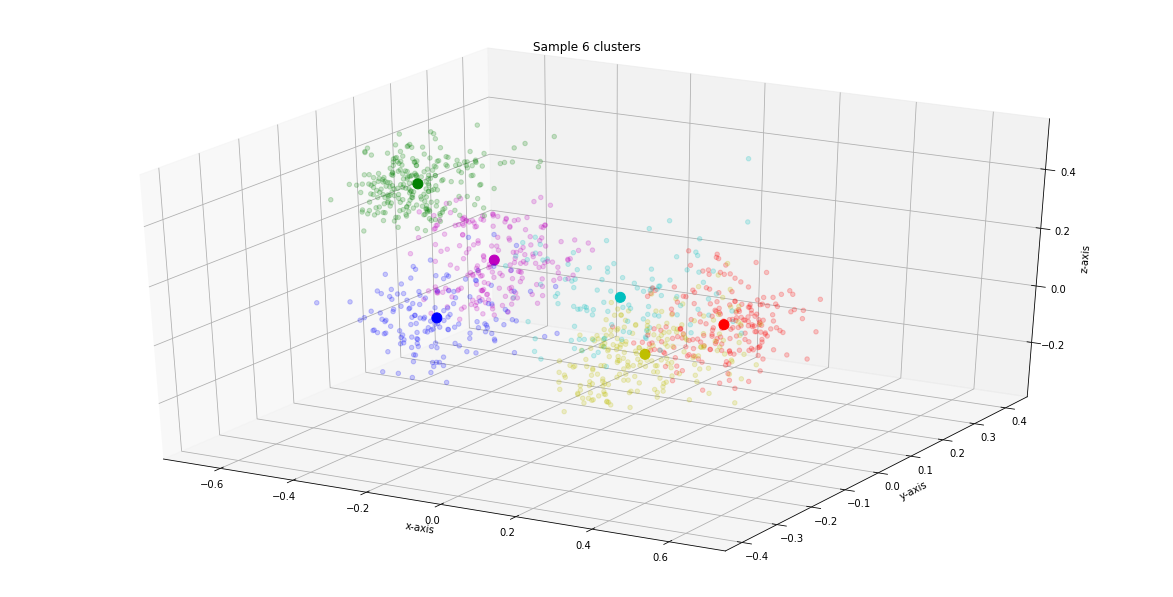

In [22]:
fig = plt.figure(figsize=(16,8))
ax = Axes3D(fig)
ax.scatter(sample_pca_descriptors[:,0], sample_pca_descriptors[:,1], sample_pca_descriptors[:,2],
           c=sample_colors,alpha=0.2)
ax.scatter(sample_pca_centers[:,0], sample_pca_centers[:,1], sample_pca_centers[:,2],
           s=100, marker = 'o',
           c=color_array, alpha=1)
ax.set_title("Sample 6 clusters")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

### (c) Bag of visual words: Hard-Sum, Soft-Sum, Soft-Max

In [23]:
def BOW(sep_descriptors_list, centers, types=None):
    assert sep_descriptors_list[0].shape[1]==centers.shape[1], "shape not matched"
    def HardSum(dist):
        def where_max(arr):
            return np.where(arr==np.max(arr))[0][0]
        maxidx = np.apply_along_axis(where_max, 1, dist)
        count = np.zeros(centers.shape[0])
        for idx in maxidx:
            count[idx] +=1
        return count/np.sum(count)
    
    def SoftSum(dist):
        dist = np.reciprocal(dist)
        def norm_sum_one(arr):
            return arr/np.sum(arr)
        normalized = np.apply_along_axis(norm_sum_one,1, dist)
        softsum = np.apply_along_axis(np.mean, 0, normalized)
        return softsum#/np.sum(softsum)
    
    def SoftMax(dist):
        dist = np.reciprocal(dist)
        def norm_sum_one(arr):
            return arr/np.sum(arr)
        normalized = np.apply_along_axis(norm_sum_one,1, dist)
        softmax = np.apply_along_axis(max, 0, normalized)
        return softmax

    result = []
    for i in range(len(sep_descriptors_list)):
        # calculate the similarity
        dist = np.dot(centers,sep_descriptors_list[i].T).T
        
        if types=="HardSum":
            a = HardSum(dist)
        elif types=="SoftSum":
            a = SoftSum(dist)
        elif types=="SoftMax":
            a = SoftMax(dist)
        else:
            raise NameError('types must be one of the following three: HardSum, SoftSum, SoftMax.')
        result.append(a)
    return np.array(result)

In [24]:
hardsum = BOW(sep_descriptors_list, centers, "HardSum")
softsum = BOW(sep_descriptors_list, centers, "SoftSum")
softmax = BOW(sep_descriptors_list, centers, "SoftMax")

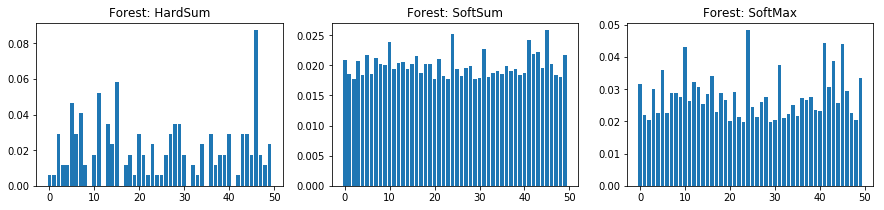

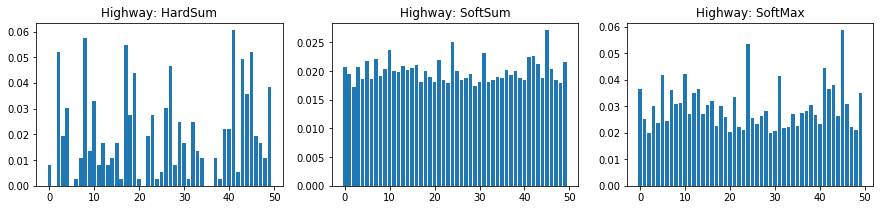

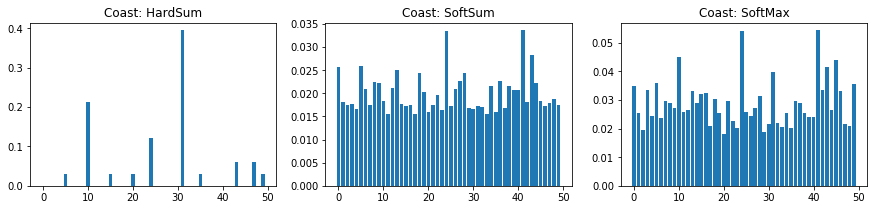

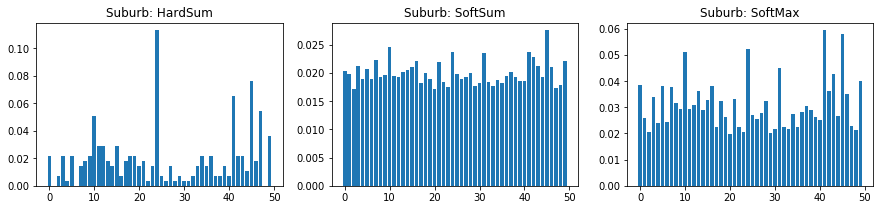

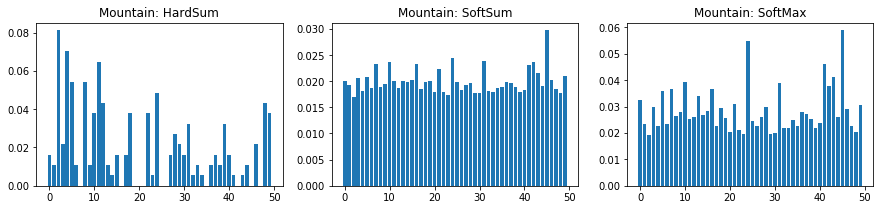

In [25]:
for i in range(5):
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.title(os.path.basename(os.path.dirname(file_list[10*i]))+": HardSum")
    plt.bar(np.arange(hardsum.shape[1]), hardsum[10*i] )
    plt.subplot(1,3,2)
    plt.title(os.path.basename(os.path.dirname(file_list[10*i]))+": SoftSum")
    plt.bar(np.arange(softsum.shape[1]), softsum[10*i] )
    plt.subplot(1,3,3)
    plt.title(os.path.basename(os.path.dirname(file_list[10*i]))+": SoftMax")
    plt.bar(np.arange(softmax.shape[1]), softmax[10*i] )
    plt.show()

I think **SoftMax** is a better BoW strategy for classification because, for an image, SoftMax preserves the maximum likely description in the each visual word. Moreover, using soft labels benefits the smoothness of decision boundaries, which is good for generalization. 

### (d-i) kNN on Test-100 

In [26]:
ytrain = np.repeat([0,1,2,3,4], repeats=10)

In [27]:
# hardsum KNN
knn_hardsum = KNeighborsClassifier(n_neighbors=10)
knn_hardsum.fit(hardsum, ytrain)

# softsum KNN
knn_softsum = KNeighborsClassifier(n_neighbors=10)
knn_softsum.fit(softsum, ytrain) 

# softmax KNN
knn_softmax = KNeighborsClassifier(n_neighbors=10)
knn_softmax.fit(softmax, ytrain)

print("Trained kNN on Train-10 dataset.")

Trained kNN on Train-10 dataset.


In [28]:
test_list = []
for dirPath, dirNames, fileNames in os.walk("Problem3/test-100/"):
    for file in fileNames:
        test_list.append(os.path.join(dirPath, file))
test_sep_points_list = []
test_sep_descriptors_list = []
for file in test_list:
    image = cv2.imread(file,0)
    points, descriptors = ExtractSURF(image,1000)
    test_sep_points_list.append(points)
    test_sep_descriptors_list.append(descriptors)
test_points_list = np.concatenate(test_sep_points_list,axis=0)
test_descriptors_list = np.concatenate(test_sep_descriptors_list,axis=0)

print("Test-100 interest points:", test_points_list.shape)
print("Test-100 descriptors:", test_descriptors_list.shape)

Test-100 interest points: (94492,)
Test-100 descriptors: (94492, 64)


In [29]:
test_hardsum = BOW(test_sep_descriptors_list, centers, "HardSum")
test_softsum = BOW(test_sep_descriptors_list, centers, "SoftSum")
test_softmax = BOW(test_sep_descriptors_list, centers, "SoftMax")

In [30]:
ytest = np.repeat([0,1,2,3,4],repeats=100)

In [31]:
print("Test-100 accuracy of HardSum: ", accuracy_score(y_pred=knn_hardsum.predict(test_hardsum), y_true=ytest))
print("Test-100 accuracy of SoftSum: ", accuracy_score(y_pred=knn_softsum.predict(test_softsum), y_true=ytest))
print("Test-100 accuracy of SoftMax: ", accuracy_score(y_pred=knn_softmax.predict(test_softmax), y_true=ytest))

Test-100 accuracy of HardSum:  0.484
Test-100 accuracy of SoftSum:  0.356
Test-100 accuracy of SoftMax:  0.488


###  (d-ii) Train on Train-100 and test on Test-100

In [32]:
train_list = []
for dirPath, dirNames, fileNames in os.walk("Problem3/train-100/"):
    for file in fileNames:
        train_list.append(os.path.join(dirPath, file))

In [33]:
train_sep_points_list = []
train_sep_descriptors_list = []
for file in train_list:
    image = cv2.imread(file,0)
    points, descriptors = ExtractSURF(image,1000)
    train_sep_points_list.append(points)
    train_sep_descriptors_list.append(descriptors)
train_points_list = np.concatenate(train_sep_points_list,axis=0)
train_descriptors_list = np.concatenate(train_sep_descriptors_list,axis=0)

print("Train-100 interest points", train_points_list.shape)
print("Train-100 descriptors:", train_descriptors_list.shape)

Train-100 interest points (102521,)
Train-100 descriptors: (102521, 64)


In [34]:
n_visual_word = 100
max_iter = 5000
n_neighbors = 10
print("C=%s clusters as visual words\n" % n_visual_word +
"Maximum iteration=%s \n" % max_iter +
"The number of k=%s nearest neighbor" % n_neighbors)

C=100 clusters as visual words
Maximum iteration=5000 
The number of k=10 nearest neighbor


In [35]:
# perform KMeans, C=100, iter=5000
kmeans = MiniBatchKMeans(n_clusters=100,max_iter=5000,batch_size=5000)
kmeans.fit(train_descriptors_list)

# get centers and cluster labels
centers = kmeans.cluster_centers_
clusters = kmeans.labels_

In [36]:
train_hardsum = BOW(train_sep_descriptors_list, centers, "HardSum")
train_softsum = BOW(train_sep_descriptors_list, centers, "SoftSum")
train_softmax = BOW(train_sep_descriptors_list, centers, "SoftMax")

In [37]:
test_hardsum = BOW(test_sep_descriptors_list, centers, "HardSum")
test_softsum = BOW(test_sep_descriptors_list, centers, "SoftSum")
test_softmax = BOW(test_sep_descriptors_list, centers, "SoftMax")

In [38]:
ytrain = np.repeat([0,1,2,3,4], repeats=100)

In [39]:
# hardsum KNN
knn_hardsum = KNeighborsClassifier(n_neighbors=10)
knn_hardsum.fit(train_hardsum, ytrain)

# softsum KNN
knn_softsum = KNeighborsClassifier(n_neighbors=10)
knn_softsum.fit(train_softsum, ytrain) 

# softmax KNN
knn_softmax = KNeighborsClassifier(n_neighbors=10)
knn_softmax.fit(train_softmax, ytrain)

print("Trained kNN on Train-100 dataset.")

Trained kNN on Train-100 dataset.


In [40]:
print("Test-100 Accuracy of HardSum: ", accuracy_score(y_pred=knn_hardsum.predict(test_hardsum), y_true=ytest))
print("Test-100 Accuracy of SoftSum: ", accuracy_score(y_pred=knn_softsum.predict(test_softsum), y_true=ytest))
print("Test-100 Accuracy of SoftMax: ", accuracy_score(y_pred=knn_softmax.predict(test_softmax), y_true=ytest))

Test-100 Accuracy of HardSum:  0.536
Test-100 Accuracy of SoftSum:  0.57
Test-100 Accuracy of SoftMax:  0.556
